In [4]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN, KMeans
import cv2

In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

# SIFT

In [5]:
def keypoints_detection_sift(input_img):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kps, dscrs = sift.detectAndCompute(gray, None)
    return kps, dscrs

In [6]:
def keypoints_matching_knn(dscrs1, dscrs2, threshold=0.6):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    knn_matches = bf.knnMatch(dscrs1, dscrs2, k=2)
    
    good_matches = []
    for neighbour_1, neighbour_2 in knn_matches:
        if neighbour_1.distance < threshold * neighbour_2.distance:
            good_matches.append(neighbour_1)
    return good_matches

In [7]:
def get_cluster_bounding_box(clusters, points, cluster_num):
    x_min = None
    for idx, c in enumerate(clusters):
        if c == cluster_num:
            x, y = points[idx]
            if x_min is None:
                x_min = x_max = x
                y_min =y_max = y
            if x< x_min:
                x_min = x
            if x> x_max:
                x_max = x
            if y<y_min:
                y_min = y
            if y>y_max:
                y_max = y
    
    return (int(x_min), int(y_min)), (int(x_max), int(y_max))


In [8]:
def find_homography(src_keypoints, dst_keypoints, matches, threshold=0.7):
    
    dst_pts = np.float32(
        [src_keypoints[m.queryIdx].pt for m in matches]
    ).reshape(-1, 1, 2)
    src_pts = np.float32(
        [dst_keypoints[m.trainIdx].pt for m in matches]
    ).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(
        src_pts,
        dst_pts,
        cv2.RANSAC,
        ransacReprojThreshold=threshold,
        maxIters=20000,
        confidence=0.995
    )

    return M, mask.ravel().tolist()

In [9]:
def get_cluster_matches(cluster_num, matches, clusters):
    return [matches[idx] for idx, v in enumerate(clusters) if v == cluster_num]

In [10]:
def find_bounding_boxes(img_kps, template_kps, cluster_matches, img_cp, template_size):
    M, _ = find_homography(img_kps, template_kps, cluster_matches, 3)
    h,w = template_size
    trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])

    transformed_corners = cv2.perspectiveTransform(trainBorder.reshape(-1, 1, 2), M)
    transformed_corners = transformed_corners.reshape(4, 2).astype(np.int32)

    queryBorder=cv2.perspectiveTransform(trainBorder ,M)[0]

    h, w = img_cp.shape[:2]
    result = [queryBorder[0][0]/w, queryBorder[0][1]/h, queryBorder[2][0]/w, queryBorder[2][1]/h]


    return [1 if i>1 else i for i in result]

          

In [11]:
def split_clusters(clusters, h, w, points):
    new_clusters = clusters.copy()
    clusters_count = len([i for i in set(clusters) if i!=-1])
    for i in range(clusters_count):
        min, max = get_cluster_bounding_box(clusters, points, i)
        cluster_h, cluster_w = max[1] - min[1], max[0] - min[0]

        if cluster_w>1.3*w:
            clusters_after_split = int(cluster_w/ w)

            def checker(x):
                for c in range(1,clusters_after_split+1):
                    if x<=min[0] + c*w:
                        return c-1
                return clusters_after_split
                    
            for idx, cluster in enumerate(clusters):
                if cluster == i:
                    x, y = points[idx]
                    new_c = checker(x)
                    if new_c>0:
                        new_clusters[idx] = clusters_count+new_c
            clusters_count+=(clusters_after_split-1)


    return new_clusters


In [15]:
def match_template(img, template, threshold = 0.6, min_samples=15, eps = 40):
    h, w = template.shape[:2]
    img_kps, img_dscrs = keypoints_detection_sift(img)
    template_kps, template_dscrs = keypoints_detection_sift(template)
    matches = keypoints_matching_knn(img_dscrs, template_dscrs, threshold=threshold)

    points = np.array(list(img_kps[m.queryIdx].pt for m in matches))

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(points)
    

    img_cp = img.copy()
    clusters_count = len([i for i in set(clusters) if i!=-1])
    new_clusters = clusters.copy()
    for i in range(clusters_count):
        min, max = get_cluster_bounding_box(clusters, points, i)
        cluster_h, cluster_w = max[1] - min[1], max[0] - min[0]
        if cluster_w>1.3*w:
            for idx, cluster in enumerate(clusters):
                if cluster == i:
                    x, y = points[idx]
                    if x > max[0]-cluster_w/2:
                        new_clusters[idx] = clusters_count    
            clusters_count+=1

    for i in range(clusters_count):
        min, max = get_cluster_bounding_box(new_clusters, points, i)
        cv2.rectangle(img_cp, min, max, color=(0, 0, 200), thickness=5)

    img_cp = img.copy()

    result = []
    for c in range(clusters_count):
        cluster_matches = [matches[idx] for idx, v in enumerate(new_clusters) if v == c]
        result.append(find_bounding_boxes(img_kps, template_kps, cluster_matches, img_cp, (h,w)))
    
    return result



In [32]:
img_path = "train"


img = skimage.io.imread(os.path.join(img_path, "train_0.jpg"))
template = skimage.io.imread(os.path.join(img_path, "template_0_0.jpg"))
h, w = template.shape[:2]
h,w

(137, 65)

417


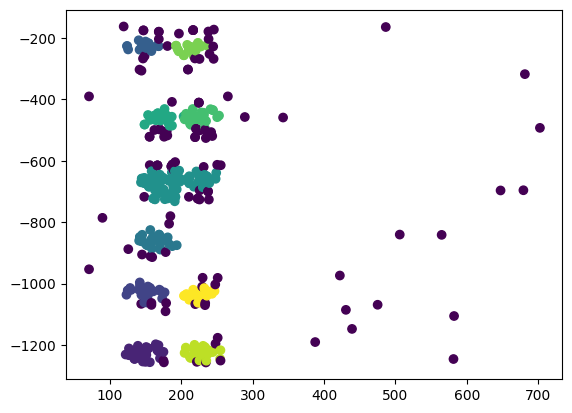

In [90]:

threshold=0.7
eps=25
min_samples=int(h*w/500)
min_samples

h, w = template.shape[:2]
img_kps, img_dscrs = keypoints_detection_sift(img)
template_kps, template_dscrs = keypoints_detection_sift(template)


matches = keypoints_matching_knn(img_dscrs, template_dscrs, threshold=threshold)
print(len(matches))

points = np.array(list(img_kps[m.queryIdx].pt for m in matches))

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(points)

mirrored_points = np.array([[x, -y] for x, y in points])

plt.figure()
plt.scatter(mirrored_points[:, 0], mirrored_points[:, 1], c=clusters)



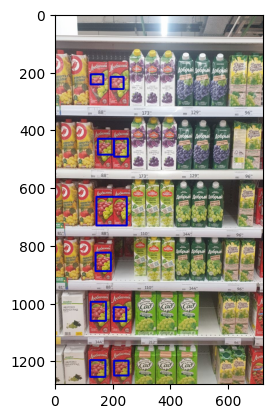

In [91]:
img_cp = img.copy()
clusters_count = len([i for i in set(clusters) if i!=-1])

for i in range(clusters_count):
    min, max = get_cluster_bounding_box(clusters, points, i)
    cv2.rectangle(img_cp, min, max, color=(0, 0, 200), thickness=5)


plt.figure()
plt.imshow(img_cp)
